In [1]:
#import Libriries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import os

In [2]:
#load data (containing 8 different 'cli_nos')
rdngs_7 = pd.read_csv('Rdngs_7.csv')
Rdngs_18708 = pd.read_csv('Rdngs_18708.csv')
cli_8rdngs = pd.concat([rdngs_7,Rdngs_18708],axis=0)

In [3]:
#chech the size of the data set
cli_8rdngs.shape

(1109741, 16)

In [4]:
#Convert the 'odometer reading' to numeric to enable computation
cli_8rdngs['odom_rdng_amt'] = pd.to_numeric(cli_8rdngs['odom_rdng_amt'], errors='coerce')

In [5]:
# Also 'odom_rdng_dt' to date time
cli_8rdngs['odom_rdng_dt'] = pd.to_datetime(cli_8rdngs['odom_rdng_dt'])

print(cli_8rdngs['odom_rdng_dt'].dtype)

datetime64[ns]


In [31]:
#Order in ascending order
cli_8rdngs = cli_8rdngs.sort_values(['spin_asset_id', 'odom_rdng_dt', 'odom_rdng_amt', 'prod_clas_cd'], ascending=[True, True, True, True])

In [33]:
# Retain one reading where there are more than one readings with same odom_rdng_dt

drop_dup = cli_8rdngs.sort_values('odom_rdng_amt', ascending=False).drop_duplicates(['odom_rdng_dt','spin_asset_id']).sort_index()
drop_dup = drop_dup.sort_values(['spin_asset_id', 'odom_rdng_dt', 'odom_rdng_amt'], ascending=[True, True, True])
drop_dup = drop_dup.drop('Unnamed: 0', axis=1)
drop_dup.head()

,cli_no,corp_cd,dan,edb_asset_id,etl_audit_insert_dt,etl_audit_update_dt,in_srvc_year,in_svc_dt,odom_rdng_amt,odom_rdng_dt,odom_rdng_qlty_val,odom_rdng_typ_cd,original_in_service_dt,prod_clas_cd,spin_asset_id
0,81,FA,JM2GL,4006791,2018-02-22 18:45:17.548,nan,2012,2012-01-05 05:00:00,877,2012-01-18 05:00:00,0,BOSS,2012-01-05 05:00:00,LT,3802610
1,81,FA,JM2GL,4006791,2018-02-22 18:45:17.548,nan,2012,2012-01-05 05:00:00,"1,369",2012-01-26 05:00:00,10,BOSS,2012-01-05 05:00:00,LT,3802610
2,81,FA,JM2GL,4006791,2018-02-22 18:45:17.548,nan,2012,2012-01-05 05:00:00,"1,800",2012-02-02 05:00:00,10,BOSS,2012-01-05 05:00:00,LT,3802610
3,81,FA,JM2GL,4006791,2018-02-22 18:45:17.548,nan,2012,2012-01-05 05:00:00,"2,229",2012-02-14 05:00:00,10,BOSS,2012-01-05 05:00:00,LT,3802610
4,81,FA,JM2GL,4006791,2018-02-22 18:45:17.548,nan,2012,2012-01-05 05:00:00,"2,621",2012-02-20 05:00:00,10,BOSS,2012-01-05 05:00:00,LT,3802610


In [34]:
def order(drop_dup,var):
    varlist =[w for w in drop_dup.columns if w not in var]
    drop_dup = drop_dup[var+varlist]
    return drop_dup 

drop_dup = order(drop_dup,['corp_cd','cli_no','spin_asset_id','odom_rdng_dt','odom_rdng_amt','odom_rdng_typ_cd','prod_clas_cd'])

In [36]:
# Create columns for date difference and reading difference
drop_dup['odom_date_diff'] = drop_dup.groupby(['spin_asset_id'])['odom_rdng_dt'].transform(lambda x: x.diff())
drop_dup['odom_rdng_diff'] = drop_dup.groupby(['spin_asset_id'])['odom_rdng_amt'].transform(lambda x: x.diff())
drop_dup.sort_index(inplace=True)

# Create 'days' column with real number
drop_dup['days'] = drop_dup['odom_date_diff'].dt.days

# Calculate the average odometer readings per day
#pd.options.display.float_format = '{:.2f}'.format
#drop_dup['avg_odom_per_day'] = (drop_dup['odom_rdng_diff']/drop_dup['days'] +.000000001) # Protect against division by zero

pd.options.display.float_format = '{:,.0f}'.format
drop_dup['avg_odom_per_day'] = (drop_dup['odom_rdng_diff']/drop_dup['days']).replace((np.inf, -np.inf), (0, 0)).clip_lower(0)

# Re-order the columns for easy reference
drop_dup = order(drop_dup,['corp_cd','cli_no','spin_asset_id','odom_rdng_dt','odom_rdng_amt','odom_date_diff','days','odom_rdng_diff','odom_rdng_typ_cd','avg_odom_per_day','prod_clas_cd'])
drop_dup = drop_dup.sort_values(['spin_asset_id', 'odom_rdng_dt', 'odom_rdng_amt'], ascending=[True, True, True])
drop_dup = drop_dup.fillna(0)

# View the first 5 rows
drop_dup.head()

,corp_cd,cli_no,spin_asset_id,odom_rdng_dt,odom_rdng_amt,odom_date_diff,days,odom_rdng_diff,odom_rdng_typ_cd,avg_odom_per_day,prod_clas_cd,dan,edb_asset_id,etl_audit_insert_dt,etl_audit_update_dt,in_srvc_year,in_svc_dt,odom_rdng_qlty_val,original_in_service_dt
0,FA,81,3802610,2012-01-18 05:00:00,877,0 days,0,0,BOSS,0,LT,JM2GL,4006791,2018-02-22 18:45:17.548,0,2012,2012-01-05 05:00:00,0,2012-01-05 05:00:00
1,FA,81,3802610,2012-01-26 05:00:00,"1,369",8 days,8,492,BOSS,62,LT,JM2GL,4006791,2018-02-22 18:45:17.548,0,2012,2012-01-05 05:00:00,10,2012-01-05 05:00:00
2,FA,81,3802610,2012-02-02 05:00:00,"1,800",7 days,7,431,BOSS,62,LT,JM2GL,4006791,2018-02-22 18:45:17.548,0,2012,2012-01-05 05:00:00,10,2012-01-05 05:00:00
3,FA,81,3802610,2012-02-14 05:00:00,"2,229",12 days,12,429,BOSS,36,LT,JM2GL,4006791,2018-02-22 18:45:17.548,0,2012,2012-01-05 05:00:00,10,2012-01-05 05:00:00
4,FA,81,3802610,2012-02-20 05:00:00,"2,621",6 days,6,392,BOSS,65,LT,JM2GL,4006791,2018-02-22 18:45:17.548,0,2012,2012-01-05 05:00:00,10,2012-01-05 05:00:00


In [37]:
clean_18117 = drop_dup[drop_dup['cli_no']==18117]

In [38]:
clean_7850 = drop_dup[drop_dup.cli_no == 7850]
clean_7850.head()

,corp_cd,cli_no,spin_asset_id,odom_rdng_dt,odom_rdng_amt,odom_date_diff,days,odom_rdng_diff,odom_rdng_typ_cd,avg_odom_per_day,prod_clas_cd,dan,edb_asset_id,etl_audit_insert_dt,etl_audit_update_dt,in_srvc_year,in_svc_dt,odom_rdng_qlty_val,original_in_service_dt
244412,FA,7850,3884177,2012-10-26 04:00:00,"90,032",0 days 00:00:00,0,0,PM3,0,LT,JT2PC,4088357,2018-02-22 19:27:20.159,0,2012,2012-09-06 04:00:00,0,2012-09-06 04:00:00
244413,FA,7850,3884177,2012-10-31 04:00:00,"1,226",5 days 00:00:00,5,"-88,806",PM3,0,LT,JT2PC,4088357,2018-02-22 19:27:20.159,0,2012,2012-09-06 04:00:00,10,2012-09-06 04:00:00
244414,FA,7850,3884177,2012-11-05 05:00:00,"1,540",5 days 01:00:00,5,314,PM3,63,LT,JT2PC,4088357,2018-02-22 19:27:20.160,0,2012,2012-09-06 04:00:00,10,2012-09-06 04:00:00
244415,FA,7850,3884177,2012-11-09 05:00:00,"1,823",4 days 00:00:00,4,283,PM3,71,LT,JT2PC,4088357,2018-02-22 19:27:20.160,0,2012,2012-09-06 04:00:00,10,2012-09-06 04:00:00
244416,FA,7850,3884177,2012-11-26 05:00:00,"2,486",17 days 00:00:00,17,663,PM3,39,LT,JT2PC,4088357,2018-02-22 19:27:20.160,0,2012,2012-09-06 04:00:00,10,2012-09-06 04:00:00


In [39]:
clean_7850_18117 = pd.concat([clean_7850,clean_18117],axis=0)

In [10]:
#drop_dup.isnull().sum()

In [11]:
# Create a new column that indicates 'yes' for negative readings and 'no' for positive readings
drop_dup['Negative'] = np.where(drop_dup['avg_odom_per_day']<0, 'yes', 'no')

In [12]:
#Total positive and negative readings after dropping duplicates 
drop_dup['Negative'].value_counts()

no     638804
yes     28357
Name: Negative, dtype: int64

In [13]:
# Create separate columns for readings greater than 1000 and readings with negative values 
drop_dup['avg_grter_1000'] = (drop_dup.avg_odom_per_day >= 1000)
drop_dup['avg_less_0'] = (drop_dup.avg_odom_per_day <0)

In [14]:
#Check total readings greater than or equal to 1000
drop_dup['avg_grter_1000'].value_counts()

False    648900
True      18261
Name: avg_grter_1000, dtype: int64

In [15]:
drop_dup['avg_less_0'].value_counts()

False    638804
True      28357
Name: avg_less_0, dtype: int64

In [16]:
#drop_dup.head()

In [17]:
grp_shw = drop_dup.groupby(['cli_no','spin_asset_id','prod_clas_cd','odom_rdng_typ_cd','avg_grter_1000','Negative']).count()['avg_odom_per_day']
grp_shw.head(20)

cli_no  spin_asset_id  prod_clas_cd  odom_rdng_typ_cd  avg_grter_1000  Negative
81      3802610        LT            BOSS              False           no          334
                                                                       yes           1
                                                       True            no            1
                                     VMA               False           no           17
                                                                       yes           5
        3802611        LT            ARM               False           no            1
                                     BOSS              False           no          324
                                                                       yes           9
                                                       True            no            2
                                     VMA               False           no           24
                                                  

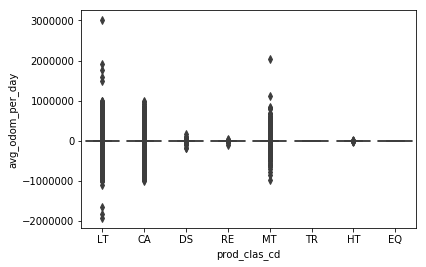

In [18]:
#See the outliers with respect to 'pro_clas_cd'
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=drop_dup);

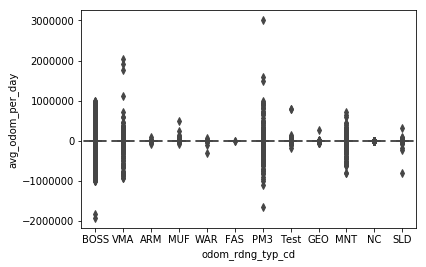

In [19]:
# In terms of 'odom_rdng_typ_cd'
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=drop_dup);

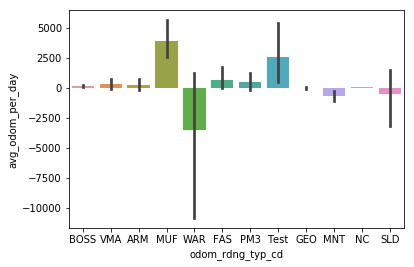

In [20]:
sns.barplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=drop_dup);

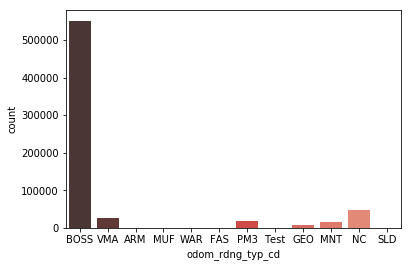

In [21]:
# Check highest source of odometer readings
sns.countplot(x="odom_rdng_typ_cd", data=drop_dup, palette="Reds_d");

In [22]:
# Total numbers of average readings per day from 1000 and above on cli_no bases
rdngs_cli_no0081 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 81)]
rdngs_cli_no1464 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 1464)]
rdngs_cli_no9051 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 9051)]
rdngs_cli_no17427 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 17427)]
rdngs_cli_no18117 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 18117)]
rdngs_cli_no7850 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 7850)]
#rdngs_cli_no18117

In [23]:
# For odometer raedings 1000 and above (cli_no 1464)
rdngs_cli_no1464.groupby(['prod_clas_cd','spin_asset_id','odom_rdng_typ_cd','Negative']).count()['avg_odom_per_day']

prod_clas_cd  spin_asset_id  odom_rdng_typ_cd  Negative
CA            3877339        VMA               no          1
              3877349        VMA               no          1
              3880197        VMA               no          1
              3881045        MUF               no          1
              3881985        MUF               no          1
              3884564        VMA               no          2
              4052980        MUF               no          1
              4052981        VMA               no          1
              4053716        VMA               no          1
              4053718        VMA               no          1
              4053722        VMA               no          1
              4053723        VMA               no          1
              4053724        VMA               no          2
              4054088        VMA               no          1
              4054938        VMA               no          1
              4054940        

In [24]:
rdngs_cli_no1464['Negative'].value_counts()

no    97
Name: Negative, dtype: int64

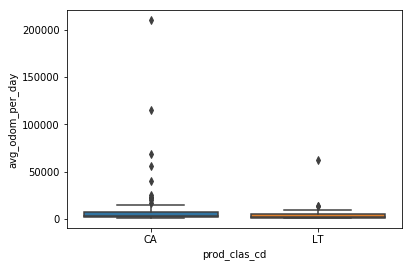

In [25]:
# Visualize to check for outliers with respect to 'pro_clas_cd' (cli_no 1464, average readings per day =>1000)
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=rdngs_cli_no1464);

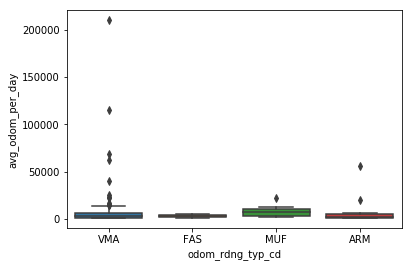

In [26]:
# Outliers in terms of 'odom_rdng_typ_cd' (cli_no 1464)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=rdngs_cli_no1464);

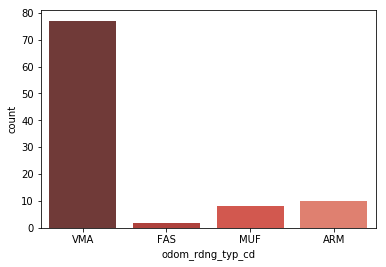

In [27]:
#Check for the highest source of odometer readings from cli_no 1464 
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no1464, palette="Reds_d");

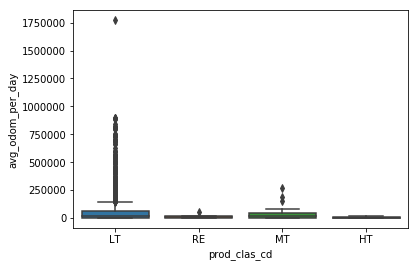

In [28]:
# In terms of 'pro_clas_cd' (cli_no 0081)
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=rdngs_cli_no0081);

In [29]:
#Check if there are negative readings for this cli_no0081 (for readings=>1000)
rdngs_cli_no0081['Negative'].value_counts()

no    1871
Name: Negative, dtype: int64

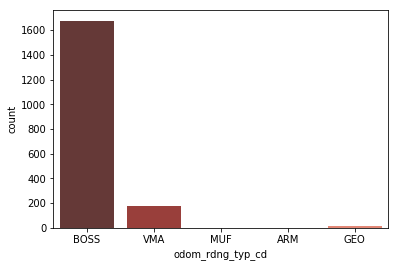

In [30]:
#Check for the highest source of odometer readings from cli_no 0081 
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no0081, palette="Reds_d");

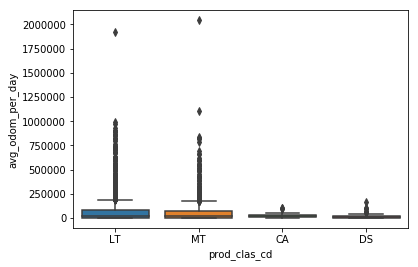

In [31]:
# In terms of 'pro_clas_cd' (cli_no 9051)
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=rdngs_cli_no9051);

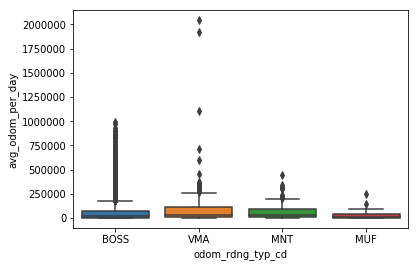

In [32]:
# Outliers in terms of 'odom_rdng_typ_cd' (cli_no 9051)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=rdngs_cli_no9051);

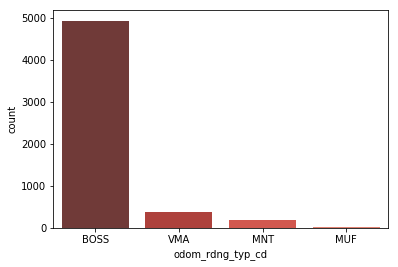

In [31]:
#Check for the highest source of odometer readings from cli_no 9051 
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no9051, palette="Reds_d");

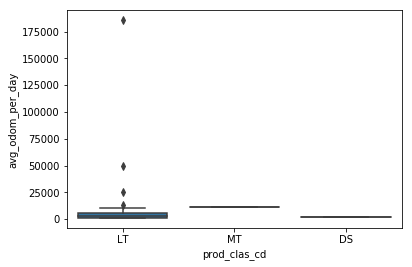

In [32]:
# With respect to 'pro_clas_cd' (cli_no 17427)
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=rdngs_cli_no17427);

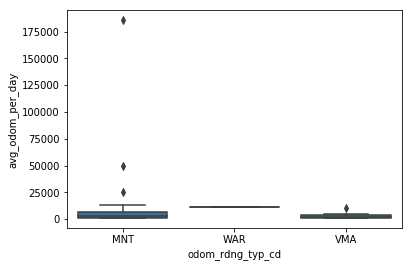

In [33]:
# Outliers in terms of 'odom_rdng_typ_cd' (cli_no 17427)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=rdngs_cli_no17427);

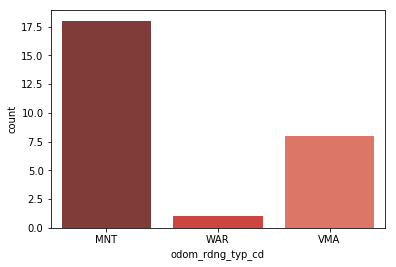

In [34]:
#Check for the highest source of odometer readings from cli_no 17427
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no17427, palette="Reds_d");

C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1830: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1856: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1863: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


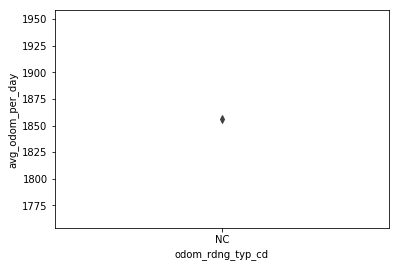

In [35]:
# Outliers in terms of 'odom_rdng_typ_cd' (cli_no 18117)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=rdngs_cli_no18117);

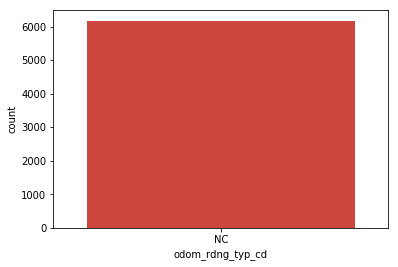

In [36]:
#Check for the highest source of odometer readings from cli_no 18117
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no18117, palette="Reds_d");

In [37]:
# Readings >= 1000 for cli_no 18708
rdngs_cli_no18708 = drop_dup[(drop_dup.avg_odom_per_day >= 1000) & (drop_dup.cli_no == 18708)]

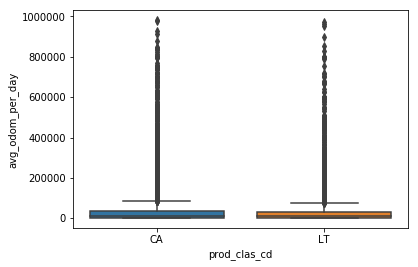

In [38]:
# Check for outliers with respect to 'prod_clas_cd'
sns.boxplot(x="prod_clas_cd", y="avg_odom_per_day", data=rdngs_cli_no18708);

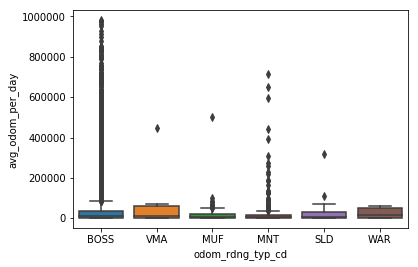

In [39]:
# In terms of odometer sources (cli_no 18708)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=rdngs_cli_no18708);

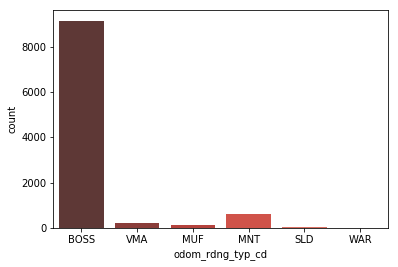

In [40]:
# Check out odometer type code with the highest readings (cli_no 18708)
sns.countplot(x="odom_rdng_typ_cd", data=rdngs_cli_no18708, palette="Reds_d");

In [ ]:
# Identify primary filters needed
# 1. Detect outliers or anomalous data instances
# 2. Handle negative values

In [42]:
# Remove outliers (IQR Method)
#drop_dup is your dataframe

grouped = drop_dup.groupby('odom_rdng_typ_cd')

In [43]:
qntile_method = pd.DataFrame({'q1': grouped['avg_odom_per_day'].quantile(.25), \
'median': grouped['avg_odom_per_day'].median(), 'q3' : grouped['avg_odom_per_day'].quantile(.75)})

In [45]:
def is_outlier(row):
    iq_range = qntile_method.loc[row.odom_rdng_typ_cd]['q3'] - qntile_method.loc[row.odom_rdng_typ_cd]['q1']
    median = qntile_method.loc[row.odom_rdng_typ_cd]['median']
    if row.avg_odom_per_day > (median + (1.5* iq_range)) or row.avg_odom_per_day < (median - (1.5* iq_range)):
        return True
    else:
        return False
#apply the function to the original drop_dup data:
drop_dup.loc[:, 'outlier'] = drop_dup.apply(is_outlier, axis = 1)
#filter to only non-outliers:
no_outliers = drop_dup[~(drop_dup.outlier)]

In [46]:
# View few rows
no_outliers.head(10)

,corp_cd,cli_no,spin_asset_id,odom_rdng_dt,odom_rdng_amt,odom_date_diff,days,odom_rdng_diff,odom_rdng_typ_cd,avg_odom_per_day,...,edb_asset_id,etl_audit_insert_dt,etl_audit_update_dt,in_svc_dt,odom_rdng_qlty_val,original_in_service_dt,Negative,avg_grter_1000,avg_less_0,outlier
0,FA,81,3802610,2012-01-18 05:00:00,877.00,0 days 00:00:00,0.00,0.00,BOSS,0.00,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,0,2012-01-05 05:00:00,no,False,False,False
1,FA,81,3802610,2012-01-26 05:00:00,1369.00,8 days 00:00:00,8.00,492.00,BOSS,61.50,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
2,FA,81,3802610,2012-02-02 05:00:00,1800.00,7 days 00:00:00,7.00,431.00,BOSS,61.57,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
3,FA,81,3802610,2012-02-14 05:00:00,2229.00,12 days 00:00:00,12.00,429.00,BOSS,35.75,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
4,FA,81,3802610,2012-02-20 05:00:00,2621.00,6 days 00:00:00,6.00,392.00,BOSS,65.33,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
5,FA,81,3802610,2012-02-24 05:00:00,3032.00,4 days 00:00:00,4.00,411.00,BOSS,102.75,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
6,FA,81,3802610,2012-03-01 05:00:00,3431.00,6 days 00:00:00,6.00,399.00,BOSS,66.50,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
7,FA,81,3802610,2012-03-07 05:00:00,3811.00,6 days 00:00:00,6.00,380.00,BOSS,63.33,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
8,FA,81,3802610,2012-03-13 04:00:00,4234.00,5 days 23:00:00,5.00,423.00,BOSS,84.60,...,4006791,2018-02-22 18:45:17.548,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False
9,FA,81,3802610,2012-03-19 04:00:00,4577.00,6 days 00:00:00,6.00,343.00,BOSS,57.17,...,4006791,2018-02-22 18:45:17.549,0.00,2012-01-05 05:00:00,10,2012-01-05 05:00:00,no,False,False,False


C:\Users\bagabi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


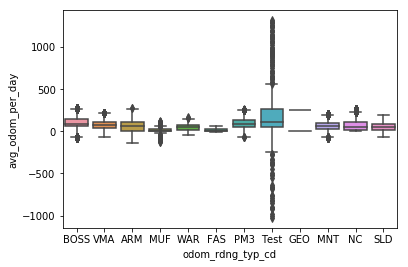

In [49]:
# To be compared with code 18 above (when outliers were still present)
sns.boxplot(x="odom_rdng_typ_cd", y="avg_odom_per_day", data=no_outliers);

In [29]:
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric


In [30]:
# Sample Clustering Algorithm with mixed data types

def gower_distance(drop_dup):
    individual_variable_distances = []

    for i in range(drop_dup.shape[1]):
        feature = drop_dup.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [47]:
df_tr = drop_dup
#df_tr.head()

In [48]:
#Transsform the odom_rdng_type_cd to dummies
df_tr = pd.get_dummies(df_tr, columns=['odom_rdng_typ_cd'])

In [53]:
drop_dup["odom_rdng_typ_cd"].unique()

array(['BOSS', 'VMA', 'ARM', 'MUF', 'WAR', 'FAS', 'PM3', 'Test', 'GEO',
       'MNT', 'NC', 'SLD'], dtype=object)

In [54]:
df_tr.head()

,corp_cd,cli_no,spin_asset_id,odom_rdng_dt,odom_rdng_amt,odom_date_diff,days,odom_rdng_diff,avg_odom_per_day,prod_clas_cd,...,odom_rdng_typ_cd_FAS,odom_rdng_typ_cd_GEO,odom_rdng_typ_cd_MNT,odom_rdng_typ_cd_MUF,odom_rdng_typ_cd_NC,odom_rdng_typ_cd_PM3,odom_rdng_typ_cd_SLD,odom_rdng_typ_cd_Test,odom_rdng_typ_cd_VMA,odom_rdng_typ_cd_WAR
0,FA,81,3802610,2012-01-18 05:00:00,877.00,0 days,0.00,0.00,0.00,LT,...,0,0,0,0,0,0,0,0,0,0
1,FA,81,3802610,2012-01-26 05:00:00,1369.00,8 days,8.00,492.00,61.50,LT,...,0,0,0,0,0,0,0,0,0,0
2,FA,81,3802610,2012-02-02 05:00:00,1800.00,7 days,7.00,431.00,61.57,LT,...,0,0,0,0,0,0,0,0,0,0
3,FA,81,3802610,2012-02-14 05:00:00,2229.00,12 days,12.00,429.00,35.75,LT,...,0,0,0,0,0,0,0,0,0,0
4,FA,81,3802610,2012-02-20 05:00:00,2621.00,6 days,6.00,392.00,65.33,LT,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 5)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [69]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


#Make a copy of drop_dup
df = drop_dup

#Transsform the odom_rdng_type_cd to dummies
df = pd.get_dummies(df, columns=['odom_rdng_typ_cd'])

#Standardize
clmns = ['cli_no','spin_asset_id','avg_odom_per_day','odom_rdng_typ_cd_FAS','odom_rdng_typ_cd_GEO',
         'odom_rdng_typ_cd_MNT','odom_rdng_typ_cd_MUF','odom_rdng_typ_cd_NC','odom_rdng_typ_cd_PM3',
        'odom_rdng_typ_cd_SLD','odom_rdng_typ_cd_Test','odom_rdng_typ_cd_VMA','odom_rdng_typ_cd_WAR',
        'odom_rdng_typ_cd_BOSS','odom_rdng_typ_cd_ARM']
df_std = stats.zscore(df[clmns])

#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_std)
labels = kmeans.labels_

#Glue back to originaal data
df['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
print(df[clmns].groupby(['clusters']).mean())

          cli_no  spin_asset_id  avg_odom_per_day  odom_rdng_typ_cd_FAS  \
clusters                                                                  
0          7,850      3,968,670               515                     0   
1         14,219      5,329,028               160                     0   
2         17,765      5,323,118              -646                     0   
3          7,459      4,679,274               316                     0   
4         18,117      5,256,509                65                     0   

          odom_rdng_typ_cd_GEO  odom_rdng_typ_cd_MNT  odom_rdng_typ_cd_MUF  \
clusters                                                                     
0                            0                     0                     0   
1                            0                     0                     0   
2                            0                     1                     0   
3                            0                     0                     0   
4     

Text(32.8863,0.5,u'avg_odom_per_day')

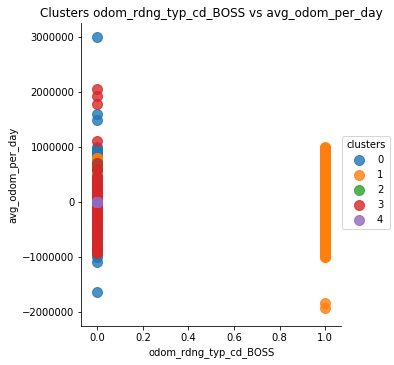

In [59]:
#Scatter plot of odom_rdng_typ_cd_BOSS and avg_odom_per_day

sns.lmplot('odom_rdng_typ_cd_BOSS', 'avg_odom_per_day', 
           data=df, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters odom_rdng_typ_cd_BOSS vs avg_odom_per_day')
plt.xlabel('odom_rdng_typ_cd_BOSS')
plt.ylabel('avg_odom_per_day')

**Clustering Algorithms continue with several methods** 

1. K-Means Clustering
2. Agglomerative Clustering
3. Spectral
4. Affinity Propagation

In [12]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [13]:
# some function for later

# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [26]:
#Make a copy of drop_dup
dt = drop_dup

#Transsform the prod_clas_cd to dummies
dt = pd.get_dummies(dt, columns=['prod_clas_cd'])

In [15]:
# Take useful feature and standardize them 
data = dt[['cli_no','spin_asset_id','avg_odom_per_day','prod_clas_cd_CA','prod_clas_cd_HT','prod_clas_cd_LT','prod_clas_cd_MT']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [48]:
pc = PCA(n_components=2)

In [49]:
dat = pca.fit_transform(data)

In [51]:
#Check out the two features selected from the Principal Component Analysis
dat = pd.DataFrame(dat)
dat.head()

,0,1
0,"-1,459,215",-148
1,"-1,459,215",-87
2,"-1,459,215",-87
3,"-1,459,215",-113
4,"-1,459,215",-83


In [52]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(dat)
dat = pd.DataFrame(np_scaled)

In [53]:
dat.head()

,0,1
0,-2,-0
1,-2,-0
2,-2,-0
3,-2,-0
4,-2,-0


In [16]:
#data.head()

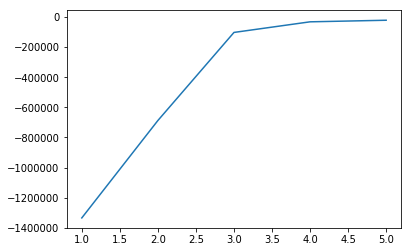

In [17]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 6)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [18]:
# Not clear for me, I choose 3 centroids arbitrarily and add these data to the central dataframe
dt['cluster'] = kmeans[2].predict(data)
dt['principal_feature1'] = data[0]
dt['principal_feature2'] = data[1]
dt['cluster'].value_counts()

0    340190
1    303670
2     23301
Name: cluster, dtype: int64

In [11]:
#dt.head()

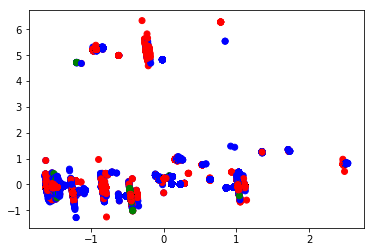

In [26]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green'}
ax.scatter(dt['principal_feature1'], dt['principal_feature2'], c=dt["cluster"].apply(lambda x: colors[x]))
plt.show()

In [34]:
#Clustering algorithm that handle categorical variables
from kmodes.kmodes import KModes

In [ ]:
print(kp.labels_)

In [27]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score


#Make a copy of drop_dup
dL = drop_dup

#Transsform the odom_rdng_type_cd to dummies
dL = pd.get_dummies(dL, columns=['odom_rdng_typ_cd'])

data = dL[['cli_no','spin_asset_id','avg_odom_per_day','odom_rdng_typ_cd_FAS','odom_rdng_typ_cd_GEO',
         'odom_rdng_typ_cd_MNT','odom_rdng_typ_cd_MUF','odom_rdng_typ_cd_NC','odom_rdng_typ_cd_PM3',
        'odom_rdng_typ_cd_SLD','odom_rdng_typ_cd_Test','odom_rdng_typ_cd_VMA','odom_rdng_typ_cd_WAR',
        'odom_rdng_typ_cd_BOSS','odom_rdng_typ_cd_ARM']]

def dataToMatrix(G):
    # Initialize data Matrix
    data = [[0 for x in range(len(G))] for y in range(len(G))]

    # For loop to set 0 or 1 ( diagonal elements are set to 1)
    for node in G:
        tempNeighList = G.neighbors(node)
        for neighbor in tempNeighList:
            data[node][neighbor] = 1
        data[node][node] = 1

    return data

# Initialize some variables to help us with the generalization of the program
kClusters = 3
results = []
nmiResults = []     #Normalized Mutual Information (NMI)
arsResults = []     #Adjusted Rand Score (ARS)

# K-means Clustering Model
kmeans = cluster.KMeans(n_clusters=kClusters, n_init=200)
kmeans.fit(data)

# Transform our data to list form and store them in results list
results.append(list(kmeans.labels_))

In [36]:
from outliers import smirnov_grubbs as grubbs

In [48]:
#drop_dup['avg_odom_per_day'] = pd.to_numeric(drop_dup['avg_odom_per_day'], errors='coerce')
#pd.options.display.float_format = '{:,.0f}'.format

In [20]:
drop_dup['avg_odom_per_day'] = drop_dup['avg_odom_per_day'].astype(int)

In [67]:
#grubbs.max_test_outliers(drop_dup['avg_odom_per_day'], alpha=0.05)

#grubbs.test(drop_dup['avg_odom_per_day'], alpha=0.05)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = (16, 9)

In [17]:
#Make a copy of drop_dup
w = drop_dup

#Transsform the odom_rdng_type_cd to dummies
w = pd.get_dummies(w, columns=['odom_rdng_typ_cd'])

data = w[['cli_no','spin_asset_id','avg_odom_per_day']]


In [20]:
# Creating a sample dataset with 4 clusters
data, y = make_blobs(n_samples=667161, n_features=3, centers=4)

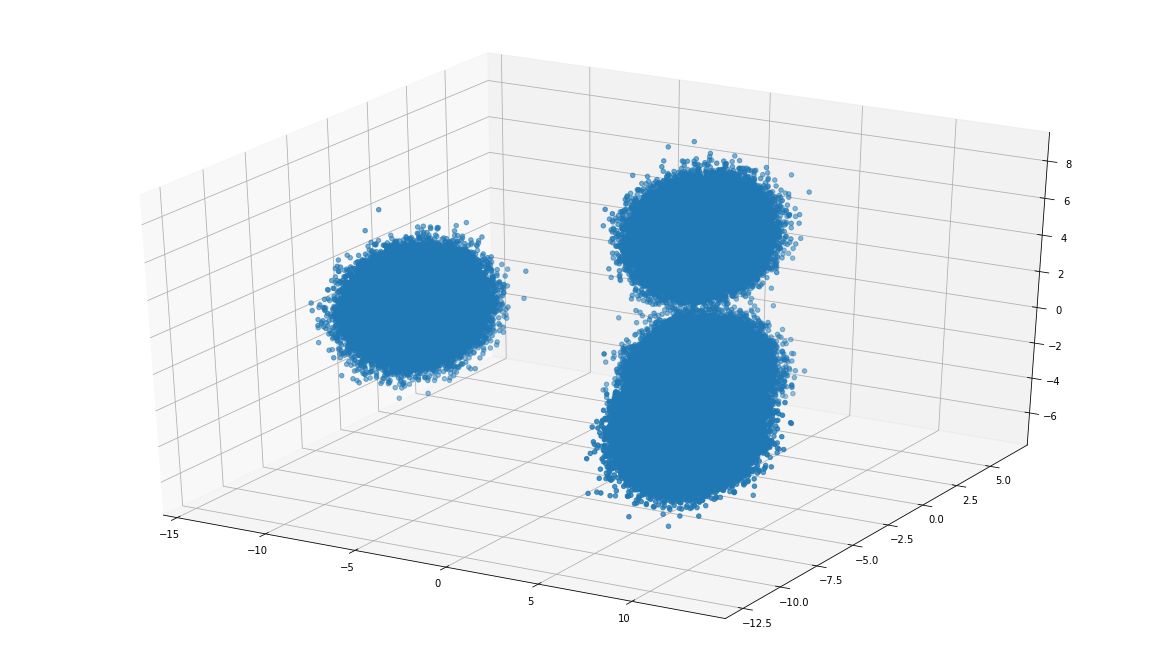

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2])

In [22]:
# Initializing KMeans
kmeans = KMeans(n_clusters=4)
# Fitting with inputs
kmeans = kmeans.fit(data)
# Predicting the clusters
labels = kmeans.predict(data)
# Getting the cluster centers
C = kmeans.cluster_centers_

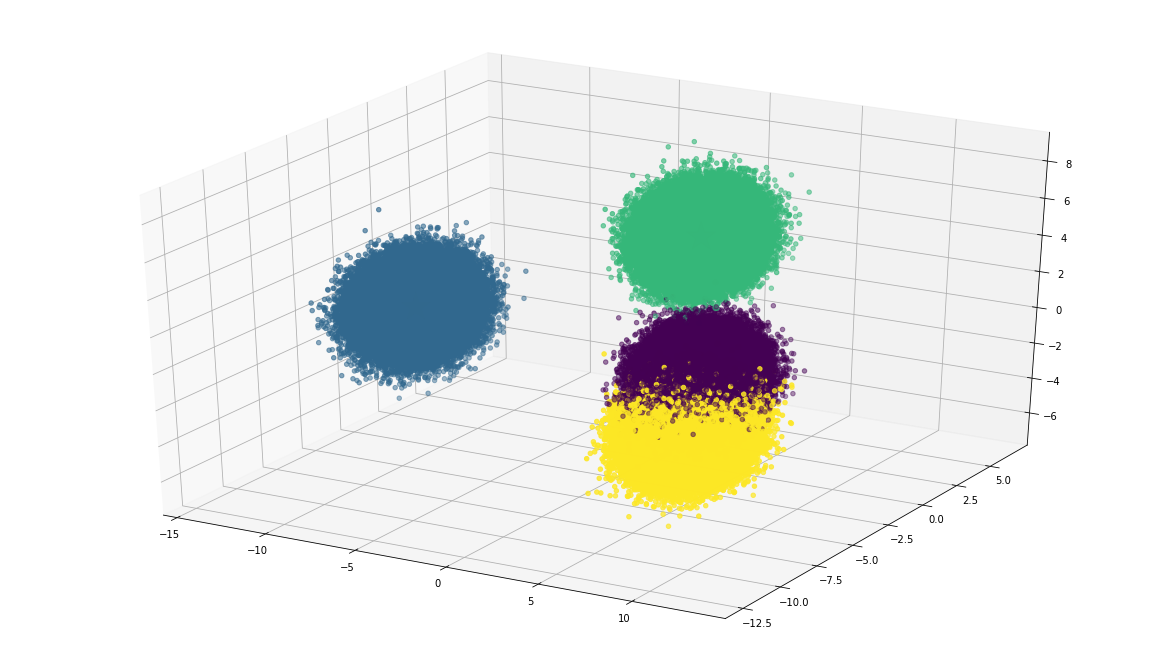

In [23]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=1000)

In [ ]:
drop_dup = order(drop_dup,['corp_cd','cli_no','spin_asset_id','odom_rdng_dt','odom_rdng_amt','odom_rdng_typ_cd','prod_clas_cd'])

In [57]:
print (clean_7850_18117.columns.tolist())

['corp_cd', 'cli_no', 'spin_asset_id', 'odom_rdng_dt', 'odom_rdng_amt', 'odom_date_diff', 'days', 'odom_rdng_diff', 'odom_rdng_typ_cd', 'avg_odom_per_day', 'prod_clas_cd', 'dan', 'edb_asset_id', 'etl_audit_insert_dt', 'etl_audit_update_dt', 'in_srvc_year', 'in_svc_dt', 'odom_rdng_qlty_val', 'original_in_service_dt']


In [60]:
drop_dup = clean_7850_18117 = order(clean_7850_18117,['corp_cd', 'cli_no', 'spin_asset_id', 'prod_clas_cd','odom_rdng_dt', 'odom_rdng_amt', 'odom_date_diff', 'days', 'odom_rdng_diff', 
                           'odom_rdng_typ_cd', 'avg_odom_per_day', 'dan', 'edb_asset_id', 'etl_audit_insert_dt', 'etl_audit_update_dt', 
                           'in_srvc_year', 'in_svc_dt', 'odom_rdng_qlty_val', 'original_in_service_dt'])

In [61]:
clean_7850_18117.head(1)

,corp_cd,cli_no,spin_asset_id,prod_clas_cd,odom_rdng_dt,odom_rdng_amt,odom_date_diff,days,odom_rdng_diff,odom_rdng_typ_cd,avg_odom_per_day,dan,edb_asset_id,etl_audit_insert_dt,etl_audit_update_dt,in_srvc_year,in_svc_dt,odom_rdng_qlty_val,original_in_service_dt
244412,FA,7850,3884177,LT,2012-10-26 04:00:00,"90,032",0 days,0,0,PM3,0,JT2PC,4088357,2018-02-22 19:27:20.159,0,2012,2012-09-06 04:00:00,0,2012-09-06 04:00:00


In [62]:
print (Rdngs_7850_18117.columns.tolist())

['corp_cd', 'cli_no', 'spin_asset_id', 'unit_no', 'prod_class_cd', 'prod_subclass_cd', 'st_prov_nm', 'tag_st_prov_abbr', 'mos_in_svc', 'drvd_make', 'drvd_model', 'asgn_stat_cd_long_desc']


In [63]:
Rdngs_7850_18117 = order(Rdngs_7850_18117,['corp_cd', 'cli_no', 'spin_asset_id', 'prod_class_cd', 
                                           'prod_subclass_cd', 'st_prov_nm', 
                                           'tag_st_prov_abbr', 'unit_no', 'mos_in_svc', 'drvd_make', 
                                           'drvd_model', 'asgn_stat_cd_long_desc'])

In [46]:
Rdngs_7850_18117 = pd.read_csv('client_18117_7850.csv')

In [64]:
Rdngs_7850_18117.head(1)

,corp_cd,cli_no,spin_asset_id,prod_class_cd,prod_subclass_cd,st_prov_nm,tag_st_prov_abbr,unit_no,mos_in_svc,drvd_make,drvd_model,asgn_stat_cd_long_desc
0,FA,18117,5251335,DS,DS,WISCONSIN,WI,99999,29,Unknown,Unknown,ASSIGNED


In [66]:
# Merging required loaded data (Task One)
df = (pd.merge(Rdngs_7850_18117, clean_7850_18117, on=['corp_cd', 'cli_no','spin_asset_id'], copy = False))


In [71]:
df.shape

(74289, 28)

In [75]:
df.to_csv('dataForCluster.csv')